In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,680.0,25.0,0.50,0.38,0.38,0.50,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.523846,0.460180,37.966864,6328.89332
1,1,514.0,25.0,0.50,0.25,0.50,0.63,77.4,46.8,64.7,55.8,27.0,45.8,1.0,0.10,0.583380,0.485219,40.813181,7502.24389
2,2,431.0,12.5,0.25,0.38,0.50,0.63,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.429001,0.408851,31.881847,4587.38557
3,3,656.0,25.0,0.50,0.38,0.38,0.50,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.404225,0.401708,30.798351,4234.86859
4,4,594.0,25.0,0.50,0.25,0.50,0.75,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.509001,0.452027,35.884011,6026.06365


In [4]:
train.columns

Index(['id', 'Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [5]:
# Define features and target
FEATURES = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
            'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
            'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
            'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']
TARGET = ['yield']

In [6]:
train_X = train[FEATURES]
train_y = train[TARGET]

In [7]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)


In [8]:
# Feature selection using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
selector = SelectFromModel(rf, threshold='median')
selector.fit(X_train, y_train.values.ravel())
train_X_selected = selector.transform(X_train)
test_selected = selector.transform(test[FEATURES])

In [9]:
# Get the selected feature names
selected_features = selector.get_support(indices=True)
selected_feature_names = [FEATURES[i] for i in selected_features]

# Convert the selected features into a DataFrame
train_X_selected = pd.DataFrame(train_X_selected, columns=selected_feature_names)

# Add interaction features based on available columns
if 'fruitset' in selected_feature_names and 'honeybee' in selected_feature_names:
    train_X_selected['interaction_1'] = train_X_selected['fruitset'] * train_X_selected['honeybee']
if 'fruitmass' in selected_feature_names:
    train_X_selected['interaction_2'] = np.log1p(train_X_selected['fruitmass'])

# Repeat the same for the test set
test_selected = pd.DataFrame(test_selected, columns=selected_feature_names)

if 'fruitset' in selected_feature_names and 'honeybee' in selected_feature_names:
    test_selected['interaction_1'] = test_selected['fruitset'] * test_selected['honeybee']
if 'fruitmass' in selected_feature_names:
    test_selected['interaction_2'] = np.log1p(test_selected['fruitmass'])


In [10]:
# Scale the data
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_selected)
test_X_scaled = scaler.transform(test_selected)

In [11]:
# Expanded hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200],  
    'learning_rate': [0.03, 0.05, 0.1],  
    'max_depth': [2, 3, 5],  
    'min_samples_split': [2, 5, 10],
    # 'subsample': [0.7, 0.8, 0.9],  
    # 'min_samples_leaf': [1, 3, 5]  
}

In [12]:
# Gradient Boosting Regressor with GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(train_X_scaled, y_train.values.ravel())

# # Set up k-fold cross-validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_results = cross_val_score(gbr, train_X_selected, train_y.values.ravel(), cv=kf, scoring='neg_mean_absolute_error')


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.05, 0.1],
                         'max_depth': [2, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

In [13]:
# Best parameters found
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [14]:
# Initialize Stacking Regressor
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
stacked_model = StackingRegressor(estimators=[
    ('gbr', grid_search.best_estimator_),  
    ('rf', rf_model)], 
    final_estimator=Ridge())

In [15]:
# Train the stacked model
stacked_model.fit(train_X_scaled, y_train.values.ravel())

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=5,
                                                         min_samples_split=5,
                                                         random_state=42)),
                              ('rf',
                               RandomForestRegressor(n_estimators=500,
                                                     random_state=42))],
                  final_estimator=Ridge())

In [16]:
# Cross-Validation with Stacking Model
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Updated to 10 folds
cv_results_stacked = cross_val_score(stacked_model, train_X_scaled, y_train.values.ravel(), cv=kf, scoring='neg_mean_absolute_error')
print(f"Stacked Model Mean CV MAE: {-np.mean(cv_results_stacked)}")

Stacked Model Mean CV MAE: 249.10946283321906


In [17]:
# Predictions on validation set
val_preds = stacked_model.predict(train_X_scaled)
mae_val = mean_absolute_error(y_train, val_preds)
print(f"Validation MAE: {mae_val}")

Validation MAE: 218.14746753690076


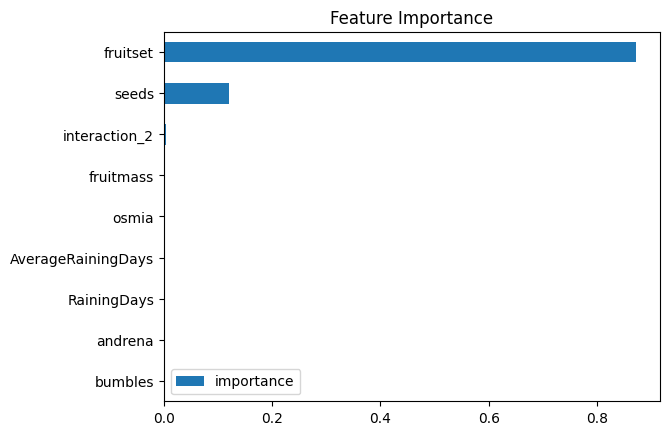

In [18]:
# Feature Importance Plot (from Gradient Boosting Model)
import matplotlib.pyplot as plt
fi = pd.DataFrame(data=grid_search.best_estimator_.feature_importances_,
                  index=train_X_selected.columns,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [19]:
# Predictions on the test set
test_predictions = stacked_model.predict(test_X_scaled)



In [20]:
# sample_submission = pd.read_csv('/kaggle/input/wild-blueberryyield-regression/sample_submission.csv')


In [21]:
# sample_submission['yield'] = test_predictions


NameError: name 'sample_submission' is not defined

In [ ]:
# sample_submission.to_csv('submission.csv', index=False)

In [22]:
test_predictions

array([6322.8955687 , 6810.11437386, 6993.65117383, ..., 4829.62012054,
       4416.40005125, 8191.80988255])

In [23]:
len(test_predictions)

10000

In [24]:
pd.DataFrame({'id': test['id'], 'yield': test_predictions}).to_csv('submission.csv', index=False)